In [5]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('order_book.csv')


In [6]:
columns_to_drop = ['Bid_Price', 'Ask_Price', 'Mid_Price',"Spread"]  # Replace with your actual column names

# Drop the specified columns from the DataFrame
df = df.drop(columns=columns_to_drop)
df


,Date,Company,Open,Close,Low,High,Volume
0,1970-01-02,GT,15.375000,15.750000,15.125000,15.875000,64600.0
1,2004-08-23,JXSB,15.260000,15.250000,15.250000,15.260000,1000.0
2,2004-08-27,FFA,20.000000,20.000000,20.000000,20.010000,368300.0
3,1998-07-10,BELFB,10.000000,9.625000,9.625000,10.000000,24800.0
4,1995-10-13,POOL,0.921811,0.921811,0.921811,0.987654,6328631.0
...,...,...,...,...,...,...,...
8023345,2022-12-06,GT,10.830000,10.670000,10.500000,10.890000,3740000.0
8023346,2022-12-07,GT,10.590000,10.650000,10.520000,10.660000,2331900.0
8023347,2022-12-08,GT,10.740000,10.650000,10.590000,10.840000,2425100.0
8023348,2022-12-09,GT,10.530000,10.520000,10.520000,10.730000,2242800.0


In [7]:
from tqdm import tqdm

def sliding_window(data, window_size, step_size):
    for i in range(0, len(data) - window_size + 1, step_size):
        yield data[i:i+window_size]


window_size = 20
step_size = 5
col = ['Open', 'Close', 'Low', 'High', 'Volume']

# Create point cloud for each company
point_clouds = {}
for company in tqdm(df['Company'].unique(), desc="Processing companies (CPU)"):
    company_data = df[df['Company'] == company]
    point_cloud = np.array(list(sliding_window(company_data[col].values, window_size, step_size)))
    point_clouds[company] = point_cloud

Processing companies (CPU): 100%|██████████| 1562/1562 [05:40<00:00,  4.59it/s]


In [4]:
for company, cloud in tqdm(point_clouds.items(), desc="Computing persistence diagrams"):
    print(f"Company: {company}, Point Cloud Shape: {cloud.shape}")


Computing persistence diagrams: 100%|██████████| 1562/1562 [00:00<00:00, 491854.57it/s]

Company: GT, Point Cloud Shape: (2668, 20, 5)
Company: JXSB, Point Cloud Shape: (289, 20, 5)
Company: FFA, Point Cloud Shape: (918, 20, 5)
Company: BELFB, Point Cloud Shape: (1226, 20, 5)
Company: POOL, Point Cloud Shape: (1357, 20, 5)
Company: AAON, Point Cloud Shape: (1505, 20, 5)
Company: BBOX, Point Cloud Shape: (1305, 20, 5)
Company: WEN, Point Cloud Shape: (2145, 20, 5)
Company: OCLR, Point Cloud Shape: (714, 20, 5)
Company: HRTX, Point Cloud Shape: (1775, 20, 5)
Company: RICK, Point Cloud Shape: (1340, 20, 5)
Company: ASYS, Point Cloud Shape: (1853, 20, 5)
Company: STLY, Point Cloud Shape: (1367, 20, 5)
Company: BECN, Point Cloud Shape: (914, 20, 5)
Company: SRCE, Point Cloud Shape: (1865, 20, 5)
Company: CMRX, Point Cloud Shape: (484, 20, 5)
Company: ULBI, Point Cloud Shape: (1503, 20, 5)
Company: STXS, Point Cloud Shape: (918, 20, 5)
Company: FAST, Point Cloud Shape: (1774, 20, 5)
Company: MGI, Point Cloud Shape: (920, 20, 5)
Company: PFIN, Point Cloud Shape: (1698, 20, 5)
Com

In [16]:
from ripser import ripser
from persim import plot_diagrams

def compute_persistence(point_cloud):
    if point_cloud.size == 0:
        print(f"Skipping empty point cloud for this entry.")
        return None

    diagrams = []
    for row in point_cloud:
        reshaped_row = row.reshape(row.shape[0], -1)
        diagram = ripser(reshaped_row, maxdim=2)['dgms']
        diagrams.append(diagram)

    return diagrams

persistence_diagrams = {}
for company, cloud in tqdm(point_clouds.items(), desc="Computing persistence diagrams"):
    diagrams = compute_persistence(cloud)

    if diagrams is not None:
        persistence_diagrams[company] = diagrams

Computing persistence diagrams:   3%|▎         | 53/1562 [00:24<11:58,  2.10it/s]

Skipping empty point cloud for this entry.


Computing persistence diagrams:  12%|█▏        | 191/1562 [01:26<10:50,  2.11it/s]

Skipping empty point cloud for this entry.


Computing persistence diagrams:  21%|██        | 331/1562 [02:50<09:14,  2.22it/s]

Skipping empty point cloud for this entry.


Computing persistence diagrams:  77%|███████▋  | 1201/1562 [08:48<02:19,  2.60it/s]

Skipping empty point cloud for this entry.


Computing persistence diagrams:  86%|████████▋ | 1348/1562 [09:52<01:32,  2.33it/s]

Skipping empty point cloud for this entry.


Computing persistence diagrams: 100%|██████████| 1562/1562 [11:22<00:00,  2.29it/s]


In [9]:
import pickle
# Dictionary to hold persistence diagrams and extracted features
persistence_diagrams = {}
# Save persistence diagrams to disk using pickle
with open('persistence_diagrams.pkl', 'wb') as f:
    pickle.dump(persistence_diagrams, f)


In [1]:
import pickle
with open('persistence_diagrams.pkl', 'rb') as f:
    persistence_diagrams = pickle.load(f)

In [10]:
import csv

# Save persistence diagrams to a CSV file
with open('persistence_diagrams.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Company', 'Dimension', 'Birth', 'Death'])
    
    for company, diag_list in persistence_diagrams.items():
        for diag in diag_list:
            for dim, points in enumerate(diag):
                for point in points:
                    writer.writerow([company, dim, point[0], point[1]])

# To load the data from CSV, you can use pandas or the csv module to parse it back.
# import pandas as pd
# df = pd.read_csv('persistence_diagrams.csv')


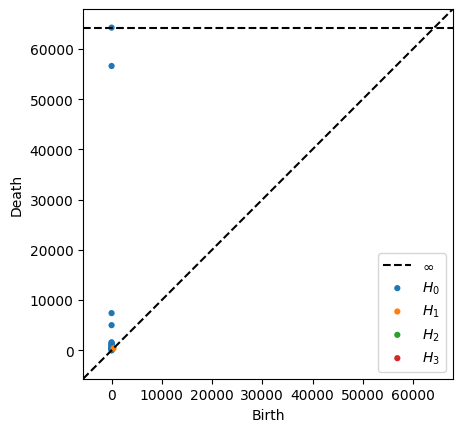

Plotted persistence diagram for HOFT


In [3]:
from persim import plot_diagrams
first_company = list(persistence_diagrams.keys())[566]
plot_diagrams(persistence_diagrams[first_company][0], show=True)
print(f"Plotted persistence diagram for {first_company}")

In [19]:
from persim import PersistenceImager
import numpy as np
def extract_features(diagrams_list):
    pi = PersistenceImager(pixel_size=0.1, birth_range=(0, 1), pers_range=(0, 1))
    features = []
    for diagrams in diagrams_list:
        if len(diagrams) > 1 and len(diagrams[1]) > 0:  # Check if 1-dimensional features exist
            img = pi.transform(diagrams[1])  # Use 1-dimensional features
            features.append(img.flatten())

    # Ensure all features are valid numeric values
    features = np.array([f for f in features if not np.isnan(f).any()])

    # Reshape the array to ensure it's a 2D array with at least one feature per sample
    if features.ndim == 1:
        features = features.reshape(-1, 1)

    return features


features_dict = {}


In [20]:
topological_features = {company: extract_features(diags) for company, diags in persistence_diagrams.items()}

In [21]:
topological_features

{'GT': array([], shape=(0, 1), dtype=float64),
 'JXSB': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'FFA': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

In [ ]:
import pandas as pd
import numpy as np

# Calculate new features
df['Daily Return'] = df.groupby('Company')['Close'].pct_change()  # Daily returns
df['Volatility'] = df.groupby('Company')['Close'].rolling(window=20).std()  # Rolling volatility (20 days)

# Drop NA values (introduced by pct_change and rolling)
df.dropna(inplace=True)


data = df[['Date', 'Close', 'Volume', 'Daily Return', 'Volatility']]
df.sort_values(['Company', 'Date'], inplace=True)
df


In [5]:
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import cudf

df = cudf.read_csv('order_book.csv')  

# Convert DataFrame columns to CuPy arrays
close_cupy = cp.asarray(df['Close'].values)
volume_cupy = cp.asarray(df['Volume'].values)

# Autocorrelation for 'Close' and 'Volume'
for feature, data in zip(['Close', 'Volume'], [close_cupy, volume_cupy]):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    
    # Calculate ACF and PACF using CuPy
    plot_acf(data.get(), ax=ax[0], title=f'{feature} Autocorrelation')
    plot_pacf(data.get(), ax=ax[1], title=f'{feature} Partial Autocorrelation')
    plt.show()

# Cross-correlation: 'Close' vs 'Volume'
cross_correlation = cp.correlate(close_cupy, volume_cupy, mode='full')
lags = cp.arange(-len(df) + 1, len(df))

# Convert cross_correlation and lags back to NumPy for plotting
cross_correlation_np = cp.asnumpy(cross_correlation)
lags_np = cp.asnumpy(lags)

# Plot cross-correlation
plt.plot(lags_np, cross_correlation_np)
plt.title('Cross-Correlation between Close and Volume')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.axhline(0, color='red', linestyle='--')
plt.show()


In [ ]:
for feature in ['Close', 'Volume']:
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_pacf(df[feature], lags=30, ax=ax)
    plt.title(f'Partial Autocorrelation for {feature}')
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR

# Assuming df has columns: 'Date', 'Company', 'Close', 'Volume'
# Calculate new features
df['Daily Return'] = df.groupby('Company')['Close'].pct_change()  # Daily returns
df['Volatility'] = df.groupby('Company')['Close'].rolling(window=20).std()  # Rolling volatility (20 days)

# Drop NA values (introduced by pct_change and rolling)
df.dropna(inplace=True)

# Pivot the data so each company's 'Close', 'Volume', etc., is in its own column
pivoted_data = df.pivot_table(index='Date', columns='Company', values=['Close', 'Volume', 'Daily Return', 'Volatility'])

# Remove any rows with NA values (due to missing data after the pivot)
pivoted_data.dropna(inplace=True)

# Prepare data for VAR model (concatenating the different features into a single array)
features = np.hstack([pivoted_data[col].values for col in pivoted_data.columns.levels[0]])

# Fit a VAR model
model = VAR(features)
fitted_model = model.fit(maxlags=15)

# Check lag order selection criteria (e.g., AIC, BIC)
print(fitted_model.summary())

# Forecast next values based on the model for all companies
forecast = fitted_model.forecast(features[-15:], steps=5)
print(forecast)


In [6]:
import cupy as cp  # Import CuPy for GPU acceleration
import pandas as pd
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

# Silence specific warnings from ripser
warnings.filterwarnings("ignore", category=UserWarning)

def compute_persistence_for_window(data, window_size, step_size):
    stability = {}
    for start in range(0, len(data) - window_size + 1, step_size):
        point_cloud = cp.array(data[start:start + window_size])  # Use CuPy array
        
        # Check if point cloud has enough rows (1 row needed)
        if len(point_cloud) > 0:
            # Reshape to 2D if necessary
            diagram = ripser(cp.asnumpy(point_cloud[np.newaxis, :]), maxdim=1)['dgms']  # Convert back to NumPy for ripser
            stability[start] = diagram
        else:
            print(f"Insufficient data for start index {start} with window size {window_size}.")
    return stability

# Define ranges for window sizes and step sizes
window_sizes = range(10, 101, 10)  
step_sizes = range(1, 21, 5)       

# Dictionary to hold stability analysis results
stability_analysis_all = {}

# Perform stability analysis for different combinations of window sizes and step sizes
for window_size in tqdm(window_sizes, desc='Window Sizes'):
    for step_size in tqdm(step_sizes, desc='Step Sizes', leave=False):
        print(f"Computing persistence for window size: {window_size}, step size: {step_size}")
        stability_analysis = compute_persistence_for_window(df['Close'].values, window_size, step_size)
        
        if stability_analysis:  # Only plot if there's data
            stability_analysis_all[(window_size, step_size)] = stability_analysis
            
            # Plot persistence diagrams for the current combination
            for start, diagram in stability_analysis.items():
                plt.figure(figsize=(8, 6))
                plot_diagrams(diagram)
                plt.title(f'Persistence Diagram (Window Size: {window_size}, Step Size: {step_size}, Start: {start})')
                plt.show()
        else:
            print(f"No valid diagrams for window size: {window_size}, step size: {step_size}.")


Window Sizes:   0%|          | 0/10 [00:00<?, ?it/s]

Computing persistence for window size: 10, step size: 1


In [9]:
import numpy as np
import pandas as pd
from ripser import ripser
from persim import plot_diagrams, bottleneck
from scipy.stats import entropy
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm

def sliding_window(data, window_size, step_size):
    for i in range(0, len(data) - window_size + 1, step_size):
        yield data[i:i+window_size]

def robust_scale_features(df):
    scaler = RobustScaler()
    cols_to_scale = ['Open', 'Close', 'Low', 'High']
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    return df

def compute_persistence_3d(point_cloud, max_dim=2):
    if point_cloud.size == 0:
        print(f"Skipping empty point cloud for this entry.")
        return None
    
    diagrams = []
    for window in point_cloud:
        diagram = ripser(window, maxdim=max_dim)['dgms']
        diagrams.append(diagram)
    return diagrams

def persistence_entropy(diagram, normalize=True):
    if len(diagram) == 0:
        return 0
    
    lifetimes = diagram[:, 1] - diagram[:, 0]
    lifetimes = lifetimes[np.isfinite(lifetimes)]
    
    if len(lifetimes) == 0:
        return 0
    
    if normalize:
        lifetimes /= np.sum(lifetimes)
    
    return entropy(lifetimes)

def betti_numbers(diagram, threshold):
    return np.sum(diagram[:, 1] > threshold) - np.sum(diagram[:, 0] > threshold)

def extract_features(diagrams):
    features = []
    for diagram_set in diagrams:
        set_features = []
        for dim in range(len(diagram_set)):
            pe = persistence_entropy(diagram_set[dim])
            betti = betti_numbers(diagram_set[dim], threshold=np.median(diagram_set[dim]))
            set_features.extend([pe, betti])
        features.append(set_features)
    return np.mean(features, axis=0)  # Average features across windows

def adaptive_window(data, base_window=20, min_windows=10):
    total_points = len(data)
    window_size = min(base_window, total_points // min_windows)
    step_size = max(1, window_size // 4)
    return window_size, step_size

def process_financial_data(df):
    point_clouds = {}
    persistence_diagrams = {}
    features = {}

    df = robust_scale_features(df)

    for company in tqdm(df['Company'].unique(), desc="Processing companies"):
        company_data = df[df['Company'] == company]
        cols = ['Open', 'Close', 'Low', 'High', 'Volume']
        
        window_size, step_size = adaptive_window(company_data)
        
        point_cloud = np.array(list(sliding_window(company_data[cols].values, window_size, step_size)))
        point_clouds[company] = point_cloud
        
        diagrams = compute_persistence_3d(point_cloud)
        if diagrams is not None:
            persistence_diagrams[company] = diagrams
            features[company] = extract_features(diagrams)

    return point_clouds, persistence_diagrams, features

def compute_distance_matrix(features):
    companies = list(features.keys())
    n = len(companies)
    distance_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            dist = np.linalg.norm(np.array(features[companies[i]]) - np.array(features[companies[j]]))
            distance_matrix[i, j] = distance_matrix[j, i] = dist
    
    return distance_matrix, companies

# Main execution
df = pd.read_csv('order_book.csv')
columns_to_drop = ['Bid_Price', 'Ask_Price', 'Mid_Price', "Spread"]
df = df.drop(columns=columns_to_drop)

point_clouds, persistence_diagrams, features = process_financial_data(df)
distance_matrix, companies = compute_distance_matrix(features)

# Now you can use the distance_matrix for further analysis, clustering, etc.

Processing companies:   0%|          | 0/1562 [00:00<?, ?it/s]/home/miso/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/miso/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Processing companies:   0%|          | 1/1562 [00:01<43:13,  1.66s/it]/home/miso/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/miso/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Processing companies:   0%|          | 2/1562 [00:02<23:45,  1.09it/s]/home/miso/miniconda3/envs/rapids-

KeyboardInterrupt: 